In [2]:
import psycopg2 as pg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
import re
import math
from collections import Counter
import missingno as msno
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, precision_score, recall_score
from sklearn.metrics import  roc_curve, f1_score, auc, precision_recall_curve
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

from xgboost import XGBClassifier

from ipywidgets import interactive, FloatSlider
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


### Useful Functions

In [3]:
# This function turns all letters to lower case and convert features containing 'sk_id_' to string format
def clean_header(df):
    id_columns = re.compile('sk_id_')
    df.columns = map(str.lower, df.columns)
    for i in df.columns:
        if id_columns.search(i):
            df[i] = df[i].astype(str)
    return df

In [4]:
# This function returns the percentage of NaN in each column
def nan_percentage(df):
    return round(((df.isnull().sum(axis = 0)) * 100 / len(df)),2).sort_values(ascending=False)

In [5]:
# This function shows the unique values of each categorical column
def categorical_unique(df):
    for i in df.select_dtypes(['object']).columns:
        print(i, ':', df.loc[:,i].unique())
        print(df.loc[:,i].dtypes)
        print('')

In [6]:
# This function Plots the default rate for all categorical features 
def cat_default_rate(df, col_size=2):
    col = col_size
    plot_num = df.select_dtypes(['object']).columns.size - 2
    row = math.ceil(plot_num / col)
    fig, axs = plt.subplots(row,col, figsize=(8*col,8*row))
    for i, col_name in enumerate(df.select_dtypes(['object']).columns[2:]):
        sns.barplot(y=col_name, x='target', data=pd.DataFrame(df.groupby(col_name).target.mean())
                    .sort_values(by='target', ascending=False).reset_index(),
                    color='maroon', ax=axs[math.floor(i/col),i%col])
    fig.tight_layout()

In [7]:
# This function shows the performance metrics from model prediction
def show_model_metrics(clf, y_test, X_test, model_type):
    y_predict = clf.predict(X_test)
    y_predict_proba = clf.predict_proba(X_test)[:,1]
    
    accuracy = accuracy_score(y_test,y_predict)
    ll = log_loss(y_test,y_predict)
    precision = precision_score(y_test,y_predict)
    f1 = f1_score(y_test,y_predict)
    recall = recall_score(y_test,y_predict)
    roc_auc = roc_auc_score(y_test,y_predict_proba)
    print('<',model_type,'Scores>')
    print('Accuracy: {}\nLog Loss: {}\nPrecision: {}\nF1: {}\nRecall :{}\nROC AUC: {}'
          .format(accuracy, ll, precision, f1, recall, roc_auc))

    fpr, tpr, thresholds = roc_curve(y_test, y_predict_proba)
    plt.plot(fpr, tpr,lw=2,c='red')
    plt.plot([0,1],[0,1],c='blue',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve - '+model_type)

In [8]:
# This function display the interactive confusion matrix
def interactive_confusion_matrix(model, y_test, X_test, model_type, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    model_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=100)
    sns.heatmap(model_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Normal', 'Default'],
           yticklabels=['Normal', 'Default'])
    plt.title('Confusion Matrix: '+model_type);
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

In [9]:
# This function reports the feature importance in dataframe format 
def rf_feature_importance_report(rf_model, features_list):
    report = pd.DataFrame(zip(features_list, rf_model.feature_importances_)).sort_values(by=1, ascending=False)
    report = report.rename(columns={0:'features',1:'feature_importance'}).reset_index().drop(columns='index')
    return report

In [10]:
# This function reports the result of cross validation
def report_cv_results(cv, result_type='all'):
    print('Cross Validation Averages:')
    if result_type=='test':
        for i in [j for j in cv.keys() if re.search('test',j)]:
            print(i, ':', cv[i].mean())
    elif result_type=='train':
        for i in [j for j in cv.keys() if re.search('train',j)]:
            print(i, ':', cv[i].mean())
    else:
        for i in cv.keys():
            print(i, ':', cv[i].mean())

### Data Imports

In [11]:
# Connect to my AWS server and 'project5' database
params = {
    'host': '3.130.17.136',
    'user': 'ubuntu',
    'port': 5432
}
connection = pg.connect(**params, dbname='project5')
cursor = connection.cursor()

In [12]:
# Query 'application_train' data using Postgresql
application_train_df = pd.read_sql("""

SELECT *
FROM application_train

""", connection)

In [13]:
# Query 'bureau' data using Postgresql
bureau_df = pd.read_sql("""

SELECT *
FROM bureau

""", connection)

In [14]:
# Query 'bureau_balance' data using Postgresql
bureau_balance_df = pd.read_sql("""

SELECT *
FROM bureau_balance

""", connection)

In [15]:
# Use clean_header function to 'application_train_df', 'bureau_df' and 'bureau_balance_df'
clean_header(application_train_df)
clean_header(bureau_df)
clean_header(bureau_balance_df);

### Data Preprocessing of bureau Dataframe

In [16]:
bureau_df.head()

,sk_id_curr,sk_id_bureau,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [17]:
bureau_df.shape

(1716428, 17)

In [18]:
# Display unique values of categorical features
categorical_unique(bureau_df)

sk_id_curr : ['215354' '162297' '402440' ... '448157' '345866' '235871']
object

sk_id_bureau : ['5714462' '5714463' '5714464' ... '5057762' '5057770' '5057778']
object

credit_active : ['Closed' 'Active' 'Sold' 'Bad debt']
object

credit_currency : ['currency 1' 'currency 2' 'currency 4' 'currency 3']
object

credit_type : ['Consumer credit' 'Credit card' 'Mortgage' 'Car loan' 'Microloan'
 'Loan for working capital replenishment' 'Loan for business development'
 'Real estate loan' 'Unknown type of loan' 'Another type of loan'
 'Cash loan (non-earmarked)' 'Loan for the purchase of equipment'
 'Mobile operator loan' 'Interbank credit'
 'Loan for purchase of shares (margin lending)']
object



In [19]:
# Show the percentages of NaN in each column
nan_percentage(bureau_df)

amt_annuity               71.47
amt_credit_max_overdue    65.51
days_enddate_fact         36.92
amt_credit_sum_limit      34.48
amt_credit_sum_debt       15.01
days_credit_enddate        6.15
credit_type                0.00
amt_credit_sum_overdue     0.00
amt_credit_sum             0.00
cnt_credit_prolong         0.00
days_credit_update         0.00
credit_day_overdue         0.00
days_credit                0.00
credit_currency            0.00
credit_active              0.00
sk_id_bureau               0.00
sk_id_curr                 0.00
dtype: float64

### Data Preprocessing of bureau_balance Dataframe

In [20]:
bureau_balance_df.head()

,sk_id_bureau,months_balance,status
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [21]:
bureau_balance_df.shape

(27299925, 3)

In [22]:
# Display unique values of categorical features
categorical_unique(bureau_balance_df)

sk_id_bureau : ['5715448' '5715449' '5715451' ... '5041172' '5041332' '5041336']
object

status : ['C' '0' 'X' '1' '2' '3' '5' '4']
object



In [23]:
# Show the percentages of NaN in each column
nan_percentage(bureau_balance_df)

status            0.0
months_balance    0.0
sk_id_bureau      0.0
dtype: float64

In [24]:
# Apply one hot encoding to feature 'status'
bureau_balance_df = pd.get_dummies(bureau_balance_df, columns=['status'])

In [25]:
bureau_balance_df.head(10)

,sk_id_bureau,months_balance,status_0,status_1,status_2,status_3,status_4,status_5,status_C,status_X
0,5715448,0,0,0,0,0,0,0,1,0
1,5715448,-1,0,0,0,0,0,0,1,0
2,5715448,-2,0,0,0,0,0,0,1,0
3,5715448,-3,0,0,0,0,0,0,1,0
4,5715448,-4,0,0,0,0,0,0,1,0
5,5715448,-5,0,0,0,0,0,0,1,0
6,5715448,-6,0,0,0,0,0,0,1,0
7,5715448,-7,0,0,0,0,0,0,1,0
8,5715448,-8,0,0,0,0,0,0,1,0
9,5715448,-9,1,0,0,0,0,0,0,0


In [26]:
# This function calculates the late score for the specified evaluation period
def get_late_score(df, months=0):
    
    months = -1*abs(months)
    if months != 0:
        df = df[df['months_balance']>=months]

    df = df.groupby('sk_id_bureau').sum().drop(columns=['months_balance','status_0','status_C','status_X'])
    df = df['status_1'] + (2*df['status_2']) + (3*df['status_3']) + (4*df['status_4']) + (5*df['status_5'])
    
    if months != 0:
        df = pd.DataFrame(df).rename(columns={0:'late_score_'+str(abs(months))+'months'})
        df = df.astype(int)
    else:
        df = pd.DataFrame(df).rename(columns={0:'late_score_all'})
    
    return df

In [27]:
# Create a new dataframe with unique sk_id_bureau
unique_sk_id_bureau = pd.DataFrame(bureau_balance_df.sk_id_bureau.unique()).sort_values(by=0)\
                        .rename(columns={0:'sk_id_bureau'})

In [29]:
# Add new features of late scores for evaluation period of 3, 6, 12 and all months
unique_sk_id_bureau = pd.merge(unique_sk_id_bureau, get_late_score(bureau_balance_df,3), on='sk_id_bureau', how='left')
unique_sk_id_bureau = pd.merge(unique_sk_id_bureau, get_late_score(bureau_balance_df,6), on='sk_id_bureau', how='left')
unique_sk_id_bureau = pd.merge(unique_sk_id_bureau, get_late_score(bureau_balance_df,12), on='sk_id_bureau', how='left')
unique_sk_id_bureau = pd.merge(unique_sk_id_bureau, get_late_score(bureau_balance_df), on='sk_id_bureau', how='left')

In [31]:
# Fill NaN values with zeroes and change the format to 'uint8'
unique_sk_id_bureau = unique_sk_id_bureau.fillna(0)
unique_sk_id_bureau[['late_score_3months','late_score_6months','late_score_12months']]\
= unique_sk_id_bureau[['late_score_3months','late_score_6months','late_score_12months']].astype('uint8')

In [32]:
unique_sk_id_bureau.head()

,sk_id_bureau,late_score_3months,late_score_6months,late_score_12months,late_score_all
0,5001709,0,0,0,0
1,5001710,0,0,0,0
2,5001711,0,0,0,0
3,5001712,0,0,0,0
4,5001713,0,0,0,0


### EDA

In [33]:
# Adding loan status from 'application_train_df' to 'bureau_df'
bureau_ana_df = pd.merge(application_train_df[['sk_id_curr','target']], bureau_df, on='sk_id_curr')

# Select features to remain in the dataframe
bureau_ana_df = bureau_ana_df[['sk_id_curr', 'sk_id_bureau', 'target', 'credit_active', 'credit_currency',
                               'days_credit', 'credit_day_overdue', 'days_credit_enddate', 'days_enddate_fact',
                               'amt_credit_max_overdue', 'cnt_credit_prolong', 'amt_credit_sum',
                               'amt_credit_sum_debt', 'amt_credit_sum_limit', 'amt_credit_sum_overdue',
                               'credit_type', 'days_credit_update', 'amt_annuity']]

In [34]:
bureau_ana_df.head()

,sk_id_curr,sk_id_bureau,target,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity
0,100974,5039813,0,Closed,currency 1,-2565,0,-2258.0,-2257.0,NaN,0,44955.000,0.0,0.0,0.0,Consumer credit,-1248,NaN
1,100974,5039815,0,Active,currency 1,-634,0,96.0,NaN,NaN,0,55809.000,10021.5,0.0,0.0,Consumer credit,-19,NaN
2,100974,5039816,0,Closed,currency 1,-2326,0,-1242.0,-1242.0,8307.00,0,257400.000,0.0,0.0,0.0,Consumer credit,-1242,NaN
3,100974,5039817,0,Closed,currency 1,-1248,0,-870.0,-870.0,4320.81,0,130025.115,0.0,0.0,0.0,Consumer credit,-870,NaN
4,100974,5039818,0,Closed,currency 1,-870,0,-452.0,-452.0,0.00,0,310929.660,0.0,0.0,0.0,Consumer credit,-452,NaN


In [35]:
# Show the correlation of features to the loan target value
bureau_ana_df.corr()['target'].sort_values()

amt_credit_sum           -0.010606
amt_credit_sum_limit     -0.005990
amt_annuity               0.000117
cnt_credit_prolong        0.001523
amt_credit_max_overdue    0.001587
amt_credit_sum_debt       0.002539
credit_day_overdue        0.002652
amt_credit_sum_overdue    0.006253
days_credit_enddate       0.026497
days_enddate_fact         0.039057
days_credit_update        0.041076
days_credit               0.061556
target                    1.000000
Name: target, dtype: float64

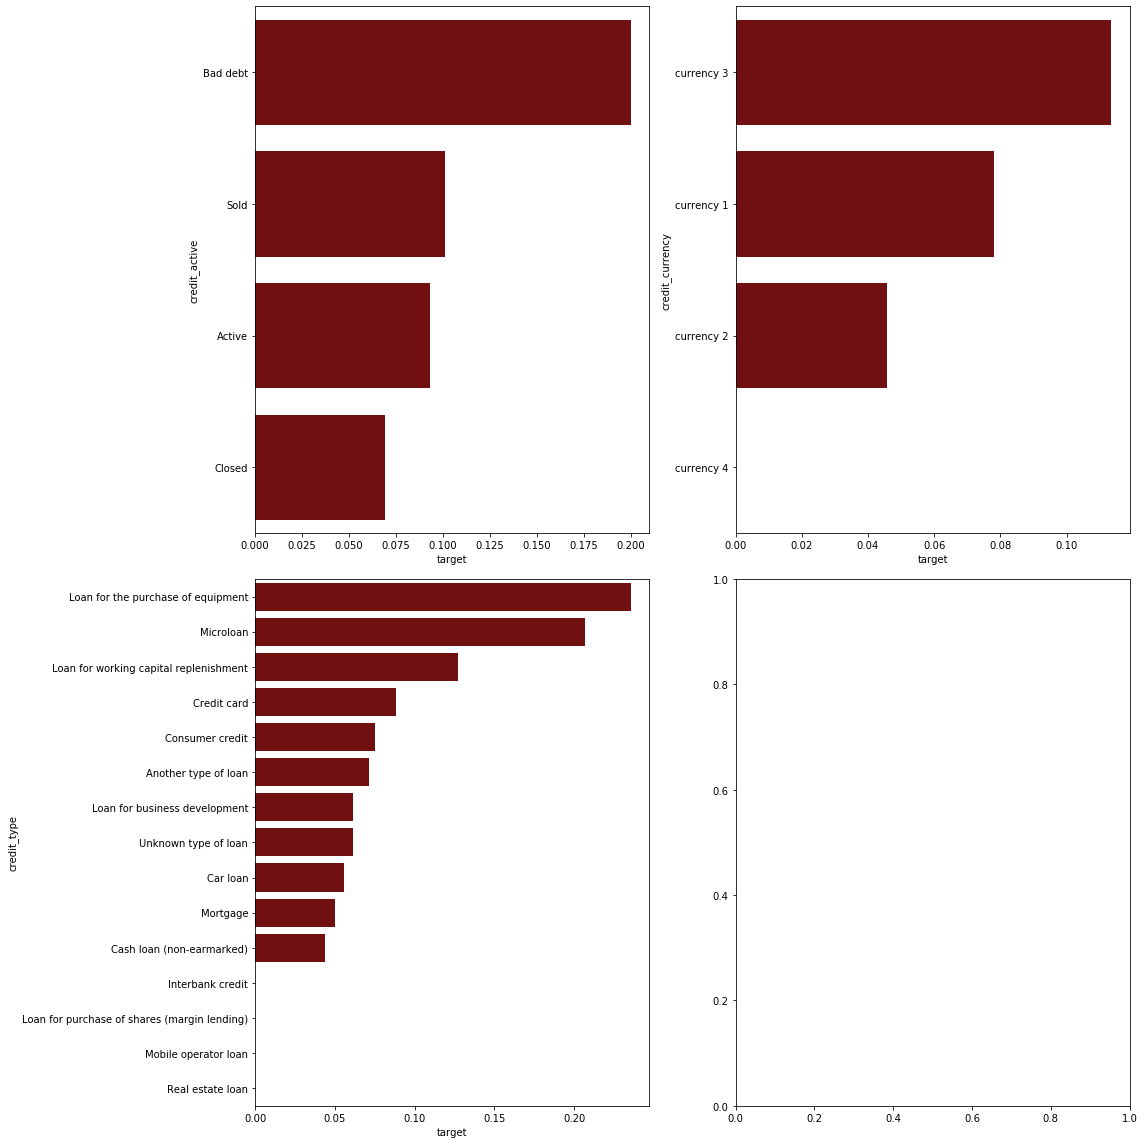

In [36]:
# Apply the function cat_default_rate to bureau dataframe to find out the default rate of categorical features
cat_default_rate(bureau_ana_df)

In [37]:
# Merge the bureau_balance data to bureau data
bureau_ana_df = pd.merge(bureau_ana_df, unique_sk_id_bureau, on='sk_id_bureau', how='left')

In [38]:
# Fill NaN values with zeroes and change the format to 'uint8'
bureau_ana_df[['late_score_3months','late_score_6months','late_score_12months','late_score_all']] =\
bureau_ana_df[['late_score_3months','late_score_6months','late_score_12months','late_score_all']]\
.fillna(0).astype('uint8')

In [39]:
# Fill NaN values with zeroes
bureau_ana_df = bureau_ana_df.fillna(0)

In [40]:
# Show the correlation of features to the loan target value
bureau_ana_df.corr()['target'].sort_values()

amt_credit_sum           -0.010606
amt_credit_sum_limit     -0.004898
amt_annuity               0.000883
amt_credit_max_overdue    0.001020
cnt_credit_prolong        0.001523
credit_day_overdue        0.002652
amt_credit_sum_debt       0.002760
amt_credit_sum_overdue    0.006253
late_score_12months       0.007469
late_score_6months        0.008329
late_score_all            0.008777
late_score_3months        0.008790
days_credit_enddate       0.024802
days_credit_update        0.041076
days_enddate_fact         0.049919
days_credit               0.061556
target                    1.000000
Name: target, dtype: float64

In [41]:
bureau_ana_df.head(1)

,sk_id_curr,sk_id_bureau,target,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity,late_score_3months,late_score_6months,late_score_12months,late_score_all
0,100974,5039813,0,Closed,currency 1,-2565,0,-2258.0,-2257.0,0.0,0,44955.0,0.0,0.0,0.0,Consumer credit,-1248,0.0,0,0,0,0


In [42]:
# Create a list of all categorical features
dummy_list = [i for i in bureau_ana_df if bureau_ana_df[i].dtypes=='object'][2:]

In [43]:
# Apply one hot encoding to categorical features
bureau_ana_df = pd.get_dummies(bureau_ana_df, columns=dummy_list, drop_first=True)

In [44]:
bureau_ana_df.head()

,sk_id_curr,sk_id_bureau,target,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,days_credit_update,amt_annuity,late_score_3months,late_score_6months,late_score_12months,late_score_all,credit_active_Bad debt,credit_active_Closed,credit_active_Sold,credit_currency_currency 2,credit_currency_currency 3,credit_currency_currency 4,credit_type_Car loan,credit_type_Cash loan (non-earmarked),credit_type_Consumer credit,credit_type_Credit card,credit_type_Interbank credit,credit_type_Loan for business development,credit_type_Loan for purchase of shares (margin lending),credit_type_Loan for the purchase of equipment,credit_type_Loan for working capital replenishment,credit_type_Microloan,credit_type_Mobile operator loan,credit_type_Mortgage,credit_type_Real estate loan,credit_type_Unknown type of loan
0,100974,5039813,0,-2565,0,-2258.0,-2257.0,0.00,0,44955.000,0.0,0.0,0.0,-1248,0.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,100974,5039815,0,-634,0,96.0,0.0,0.00,0,55809.000,10021.5,0.0,0.0,-19,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,100974,5039816,0,-2326,0,-1242.0,-1242.0,8307.00,0,257400.000,0.0,0.0,0.0,-1242,0.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,100974,5039817,0,-1248,0,-870.0,-870.0,4320.81,0,130025.115,0.0,0.0,0.0,-870,0.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,100974,5039818,0,-870,0,-452.0,-452.0,0.00,0,310929.660,0.0,0.0,0.0,-452,0.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [45]:
# Create aggregation dictionary that will be use with dataframe that groups 'sk_id_curr' together
agg_dict = {}
for i in bureau_ana_df:
    if (bureau_ana_df[i].dtypes=='float64') or (bureau_ana_df[i].dtypes=='int64'):
        agg_dict[i] = 'mean'
    elif bureau_ana_df[i].dtypes=='uint8':
        agg_dict[i] = 'sum'
agg_dict['sk_id_bureau'] = 'count'

In [46]:
# Group bureau dataframe by 'sk_id_curr' and apply custom aggregation
bureau_ana_df = bureau_ana_df.groupby('sk_id_curr').agg(agg_dict)

In [47]:
# Show the correlation of features to the loan target value
bureau_ana_df.corr()['target'].sort_values()

credit_active_Closed                                       -0.030812
credit_type_Mortgage                                       -0.023307
credit_type_Car loan                                       -0.020817
amt_credit_sum                                             -0.019956
amt_credit_sum_limit                                       -0.010805
credit_type_Consumer credit                                -0.010707
credit_currency_currency 2                                 -0.006003
credit_type_Loan for business development                  -0.003783
credit_type_Real estate loan                               -0.002704
credit_type_Unknown type of loan                           -0.002265
credit_currency_currency 4                                 -0.001692
credit_type_Loan for purchase of shares (margin lending)   -0.001128
credit_type_Cash loan (non-earmarked)                      -0.001054
credit_type_Mobile operator loan                           -0.000564
credit_type_Interbank credit      

In [48]:
bureau_ana_df.head()

,target,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,days_credit_update,amt_annuity,late_score_3months,late_score_6months,late_score_12months,late_score_all,credit_active_Bad debt,credit_active_Closed,credit_active_Sold,credit_currency_currency 2,credit_currency_currency 3,credit_currency_currency 4,credit_type_Car loan,credit_type_Cash loan (non-earmarked),credit_type_Consumer credit,credit_type_Credit card,credit_type_Interbank credit,credit_type_Loan for business development,credit_type_Loan for purchase of shares (margin lending),credit_type_Loan for the purchase of equipment,credit_type_Loan for working capital replenishment,credit_type_Microloan,credit_type_Mobile operator loan,credit_type_Mortgage,credit_type_Real estate loan,credit_type_Unknown type of loan,sk_id_bureau
sk_id_curr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,1,-874.000000,0.0,-261.750000,-523.125,1050.643125,0.0,108131.945625,30722.625,3998.570625,0.0,-499.875,0.0,0,0.0,0.0,27.0,0,6,0,0,0,0,0,0,4,4,0,0,0,0,0,0,0,0,0,0,8
100003,0,-1400.750000,0.0,-544.500000,-823.000,0.000000,0.0,254350.125000,0.000,202500.000000,0.0,-816.000,0.0,0,0.0,0.0,0.0,0,3,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,4
100004,0,-867.000000,0.0,-488.500000,-532.500,0.000000,0.0,94518.900000,0.000,0.000000,0.0,-532.000,0.0,0,0.0,0.0,0.0,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,2
100007,0,-1149.000000,0.0,-783.000000,-783.000,0.000000,0.0,146250.000000,0.000,0.000000,0.0,-783.000,0.0,0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
100008,0,-757.333333,0.0,-391.333333,-606.000,0.000000,0.0,156148.500000,80019.000,0.000000,0.0,-611.000,0.0,0,0.0,0.0,0.0,0,2,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,3


### Use RF to pick important features

In [49]:
# Splitting data to independent and dependent variables
y = bureau_ana_df.iloc[:,0]
X = bureau_ana_df.drop(columns=['target'])

In [50]:
print('Base: Data classes before splitting: ',sorted(Counter(y).items()))

Base: Data classes before splitting:  [(0, 243123), (1, 20368)]


In [51]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=88)
print('Data classes after splitting')
print('Base Train data: ',sorted(Counter(y_train).items()))
print('Base Test data: ',sorted(Counter(y_test).items()))

Data classes after splitting
Base Train data:  [(0, 194498), (1, 16294)]
Base Test data:  [(0, 48625), (1, 4074)]


In [52]:
# Scale data using StandardScaler
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)

In [53]:
# Apply ADAYSN due to imbalanced classes
adaysn = ADASYN(random_state=77)
X_train_scaled, y_train = adaysn.fit_resample(X_train_scaled, y_train)
print('Train data: ',sorted(Counter(y_train).items()))
print('Test data: ',sorted(Counter(y_test).items()))

Train data:  [(0, 194498), (1, 194243)]
Test data:  [(0, 48625), (1, 4074)]


In [54]:
# Fit training data to Random Forest
rf = RandomForestClassifier(bootstrap=True, max_depth= 3, n_estimators=150, random_state=77)
rf.fit(X_train_scaled , y_train);

< Random Forest Scores>
Accuracy: 0.6462171957722158
Log Loss: 12.219478843548268
Precision: 0.11389654441382234
F1: 0.18734199285153866
Recall :0.5274914089347079
ROC AUC: 0.6231145075738933


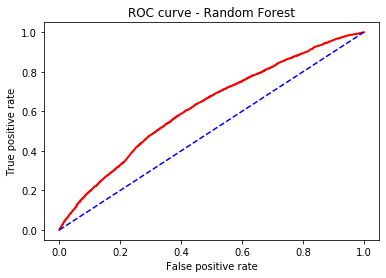

In [55]:
show_model_metrics(rf, y_test, X_test_scaled, 'Random Forest')

In [56]:
# Interactive confusion matrix with threshold sldier! 
interactive(lambda threshold: interactive_confusion_matrix(rf, y_test, X_test_scaled , 'Random Forest',
                                                           threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [57]:
# Get the important features
feature_importance_df = rf_feature_importance_report(rf, X_train.columns)
feature_importance_df 

,features,feature_importance
0,amt_credit_max_overdue,0.254612
1,amt_credit_sum_debt,0.163337
2,amt_credit_sum_limit,0.126632
3,amt_annuity,0.118434
4,days_credit,0.062875
5,days_enddate_fact,0.048676
6,credit_active_Closed,0.041267
7,days_credit_update,0.039271
8,days_credit_enddate,0.031705
9,late_score_all,0.026373


In [58]:
# Create list of important features
rf_important_features_list = list(feature_importance_df[feature_importance_df['feature_importance']!=0]['features'])

In [59]:
bureau_ana_df[rf_important_features_list].head()

,amt_credit_max_overdue,amt_credit_sum_debt,amt_credit_sum_limit,amt_annuity,days_credit,days_enddate_fact,credit_active_Closed,days_credit_update,days_credit_enddate,late_score_all,sk_id_bureau,late_score_12months,credit_type_Consumer credit,amt_credit_sum,credit_type_Credit card,amt_credit_sum_overdue,credit_day_overdue,late_score_3months,late_score_6months,credit_type_Microloan,credit_type_Mortgage,credit_type_Car loan,cnt_credit_prolong,credit_active_Sold,credit_type_Unknown type of loan
sk_id_curr,,,,,,,,,,,,,,,,,,,,,,,,,
100002,1050.643125,30722.625,3998.570625,0.0,-874.000000,-523.125,6,-499.875,-261.750000,27.0,8,0.0,4,108131.945625,4,0.0,0.0,0,0.0,0,0,0,0.0,0,0
100003,0.000000,0.000,202500.000000,0.0,-1400.750000,-823.000,3,-816.000,-544.500000,0.0,4,0.0,2,254350.125000,2,0.0,0.0,0,0.0,0,0,0,0.0,0,0
100004,0.000000,0.000,0.000000,0.0,-867.000000,-532.500,2,-532.000,-488.500000,0.0,2,0.0,2,94518.900000,0,0.0,0.0,0,0.0,0,0,0,0.0,0,0
100007,0.000000,0.000,0.000000,0.0,-1149.000000,-783.000,1,-783.000,-783.000000,0.0,1,0.0,1,146250.000000,0,0.0,0.0,0,0.0,0,0,0,0.0,0,0
100008,0.000000,80019.000,0.000000,0.0,-757.333333,-606.000,2,-611.000,-391.333333,0.0,3,0.0,3,156148.500000,0,0.0,0.0,0,0.0,0,0,0,0.0,0,0


In [60]:
# Create a bureau dataset which contains important features to be exported and used with main dataset
bureau_transfer_df = bureau_ana_df[rf_important_features_list]
bureau_transfer_df.columns = ['bu_'+i for i in bureau_transfer_df.columns]
bureau_transfer_df.head()

,bu_amt_credit_max_overdue,bu_amt_credit_sum_debt,bu_amt_credit_sum_limit,bu_amt_annuity,bu_days_credit,bu_days_enddate_fact,bu_credit_active_Closed,bu_days_credit_update,bu_days_credit_enddate,bu_late_score_all,bu_sk_id_bureau,bu_late_score_12months,bu_credit_type_Consumer credit,bu_amt_credit_sum,bu_credit_type_Credit card,bu_amt_credit_sum_overdue,bu_credit_day_overdue,bu_late_score_3months,bu_late_score_6months,bu_credit_type_Microloan,bu_credit_type_Mortgage,bu_credit_type_Car loan,bu_cnt_credit_prolong,bu_credit_active_Sold,bu_credit_type_Unknown type of loan
sk_id_curr,,,,,,,,,,,,,,,,,,,,,,,,,
100002,1050.643125,30722.625,3998.570625,0.0,-874.000000,-523.125,6,-499.875,-261.750000,27.0,8,0.0,4,108131.945625,4,0.0,0.0,0,0.0,0,0,0,0.0,0,0
100003,0.000000,0.000,202500.000000,0.0,-1400.750000,-823.000,3,-816.000,-544.500000,0.0,4,0.0,2,254350.125000,2,0.0,0.0,0,0.0,0,0,0,0.0,0,0
100004,0.000000,0.000,0.000000,0.0,-867.000000,-532.500,2,-532.000,-488.500000,0.0,2,0.0,2,94518.900000,0,0.0,0.0,0,0.0,0,0,0,0.0,0,0
100007,0.000000,0.000,0.000000,0.0,-1149.000000,-783.000,1,-783.000,-783.000000,0.0,1,0.0,1,146250.000000,0,0.0,0.0,0,0.0,0,0,0,0.0,0,0
100008,0.000000,80019.000,0.000000,0.0,-757.333333,-606.000,2,-611.000,-391.333333,0.0,3,0.0,3,156148.500000,0,0.0,0.0,0,0.0,0,0,0,0.0,0,0


In [ ]:
# Save bureau dataset with important features as pickle file
with open('bureau_transfer.pickle', 'wb') as to_write:
    pickle.dump(bureau_transfer_df, to_write)